# RNN Model

## Data Import


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import keras_tuner as kt
from keras.layers import SimpleRNN, Dense, BatchNormalization
from keras.models import Sequential
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

In [2]:
df_train = pd.read_csv("dataset/output/no-oversampling/train.csv")
df_test = pd.read_csv("dataset/output/test.csv")

## Data Preparation


In [3]:
# split into X_train, y_train, X_test, y_test
X_train = df_train.drop(columns=["target"])
y_train = df_train["target"]
X_test = df_test.drop(columns=["target"])
y_test = df_test["target"]

# normalize data
X_train = normalize(X_train)
X_test = normalize(X_test)
y_train = normalize(y_train.values.reshape(-1, 1))
y_test = normalize(y_test.values.reshape(-1, 1))

## Helper Functions


In [4]:
# This plots the auc against iteration to detect overfitting
def plot_hist(hist, metric="accuracy"):
    plt.plot(hist.history[metric])
    plt.plot(hist.history["val_" + metric])
    plt.title(f"model performance")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    return

## Model Building


### Base Model


In [5]:
def create_model():
    model = Sequential()
    model.add(
        SimpleRNN(
            128,
            input_shape=(X_train.shape[1], 1),
            activation="relu"
        )
    )
    model.add(Dense(10, activation="relu"))
    model.add(Dense(1))
    model.compile(
        loss='mean_squared_error', 
        optimizer='rmsprop', 
        metrics=['accuracy']
    )
    return model

In [6]:
model = create_model()
model.summary()
history = model.fit(
    X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               16640     
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 17941 (70.08 KB)
Trainable params: 17941 (70.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
281/281 [==============================] - 2s 3ms/step - loss: 0.2361 - accuracy: 0.6260 - val_loss: 0.2302 - val_accuracy: 0.6588
Epoch 2/100
281/281 [==============================] - 1s 2ms/step - loss: 0.2305 - accuracy: 0.6404 - val_loss: 0.2227 - val_accuracy: 0.6588
Epoch 3/100
281/281 [==============================] - 1s 2ms/step - loss: 0.2294 - accuracy: 0.6436 - val_loss: 0.2242 - val_accuracy: 0.6579
Epoch 4/100
281/281 [==============================] - 1s 2ms/step - loss: 0.2292 - accuracy: 0.6426 - val_loss: 0.2243 - val_accuracy: 0.6521
Epoch 5/100
281/281 [==============================] - 1s 2ms/step - loss: 0.2291 - accuracy: 0.6467 - val_loss: 0.2328 - val_accuracy: 0.6583
Epoch 6/100
281/281 [==============================] - 1s 2ms/step - loss: 0.2293 - accuracy: 0.6462 - val_loss: 0.2222 - val_accuracy: 0.6717
Epoch 7/100
281/281 [==============================] - 1s 2ms/step - loss: 0.2284 - accuracy: 0.6456 - val_loss: 0.2216 - val_accuracy: 0.6588

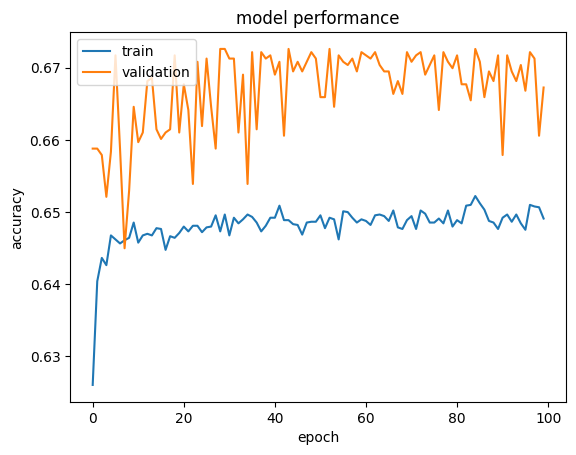

In [7]:
plot_hist(history)

In [8]:
# print confusion matrix and accuracy
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix: \n", cm)
print("\nclassification_report: \n", classification_report(y_test, y_pred))

71/71 [==============================] - 0s 1ms/step
Accuracy:  0.6672613737734165

Confusion Matrix: 
 [[1391   55]
 [ 691  105]]

classification_report: 
               precision    recall  f1-score   support

         0.0       0.67      0.96      0.79      1446
         1.0       0.66      0.13      0.22       796

    accuracy                           0.67      2242
   macro avg       0.66      0.55      0.50      2242
weighted avg       0.66      0.67      0.59      2242



### Tuned Model


In [9]:
def tune_model(hp):
    units = hp.Choice('units', [128, 256, 512])
    activation = hp.Choice('activation', ['relu', 'tanh'])
    batch_norm = hp.Boolean('batch_norm')

    model = Sequential()
    model.add(
        SimpleRNN(
            units=units,
            input_shape=(X_train.shape[1], 1),
            activation=activation
        )
    )
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Dense(10, activation="relu")) 
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])
    return model

tuner = kt.GridSearch(
    tune_model,
    objective='val_accuracy',
    max_trials=10,
    directory="tuned_models",
    project_name="thyroid_rnn_tuning",
)

tuner.search(X_train, y_train, epochs=20, validation_split=0.2)

INFO:tensorflow:Reloading Tuner from tuned_models\thyroid_rnn_tuning\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [10]:
best_hp = tuner.get_best_hyperparameters(num_trials = 1)[0]
best_model = tuner.hypermodel.build(best_hp)

In [11]:
best_model.summary()
history = best_model.fit(
    X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 512)               263168    
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 268309 (1.02 MB)
Trainable params: 268309 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
281/281 [==============================] - 4s 12ms/step - loss: 0.2391 - accuracy: 0.6173 - val_loss: 0.2297 - val_accuracy: 0.6450
Epoch 2/100
281/281 [==============================] - 3s 11ms/step - loss: 0.2328 - accuracy: 0.6310 - val_loss: 0.2253 - val_accuracy: 0

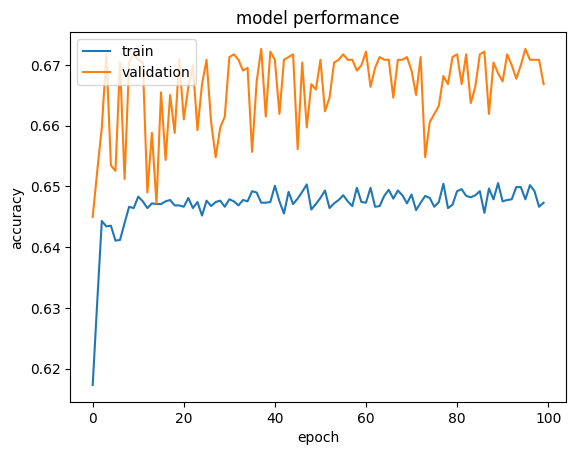

In [12]:
plot_hist(history)

In [13]:
# print confusion matrix and accuracy
y_pred = best_model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix: \n", cm)
print("\nclassification_report: \n", classification_report(y_test, y_pred))

71/71 [==============================] - 0s 3ms/step
Accuracy:  0.6668153434433541

Confusion Matrix: 
 [[1384   62]
 [ 685  111]]

classification_report: 
               precision    recall  f1-score   support

         0.0       0.67      0.96      0.79      1446
         1.0       0.64      0.14      0.23       796

    accuracy                           0.67      2242
   macro avg       0.66      0.55      0.51      2242
weighted avg       0.66      0.67      0.59      2242

